In this notebook, we will explore the sound data of the [UrbanSound8k](https://urbansounddataset.weebly.com/urbansound8k.html). (see [README](./data/UrbanSound8K_README.txt) for more details).

We will use exploratory data analysis (EDA) techniques to understand trends and patterns in the data. 

Next, we will create prediction models in the form of neural networks to solve a sound classification problem with 10 classes.

Finally, we will evaluate the performance of the different models and make a conclusion on the results obtained. 

# Setup

In [1]:
# Reload 'utils.py'
import utils
from importlib import reload
reload(utils)

<module 'utils' from 'C:\\Users\\grond\\Documents\\projects\\sound_project\\utils.py'>

In [2]:
import os

import scipy.io.wavfile as wavfile

import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import IPython.display as ipd

import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras

from kerastuner.tuners import BayesianOptimization

from scikeras.wrappers import KerasClassifier

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from utils import *

C:\Users\grond\AppData\Local\Temp\ipykernel_22576\2699683806.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [3]:
# Set style
%matplotlib inline
set_default()

In [4]:
# Use GPU or CPU for tensorflow:
# If you have a GPU and it print "No GPU available" please:
# 1) Uninstall your old tensorflow
# 2) Install tensorflow-gpu: pip install tensorflow-gpu
try_gpu() 

No GPU available


In [5]:
# Define the file paths
ROOT_PATH = "./data/"
AUDIO_PATH = os.path.join(ROOT_PATH, "audio/fold")
CREATION_PATH = os.path.join(ROOT_PATH, "creation")

# Metadata dataframe
METADATA_PATH = os.path.join(ROOT_PATH, "metadata/UrbanSound8k.csv")

# Dataframe created
AUDIO_DATA_PATH = os.path.join(CREATION_PATH, "audio_data.pkl")
MELSPECTROGRAM_PATH = os.path.join(CREATION_PATH, "melspectrogram.pkl")
MFCCS_PATH = os.path.join(CREATION_PATH, "mfccs.pkl")

# Selected model
BEST_MODEL_PATH = "sound_project_model"


# Loading Metadata for Audio Classification: Exploring Urban Sound Dataset

In [6]:
# Load metadata from UrbanSound8k.csv file
metadata = load_data(METADATA_PATH)

In [7]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


We find well the information indicated in the associated [README](./data/UrbanSound8K_README.txt). All objects are strings.

In [9]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


What we can conclude from this first information is that the average duration of a sound is 42 (mean start) - 38 (mean end) = 4s. The study will focus on sounds of short duration.

In [10]:
# For simplicity, we add the complete file path of each audio file to the 'signal_path' column
metadata['signal_path'] = AUDIO_PATH + metadata['fold'].astype(str) + '/' + metadata['slice_file_name']

In [11]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,signal_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,./data/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,./data/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,./data/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,./data/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,./data/audio/fold5/100263-2-0-137.wav


# Exploratory Data Analysis (EDA) of Urban Sound Dataset for Audio Classification

In [12]:
# Type of library to use
WAVFILE = 'wavfile'
LIBROSA = 'librosa'

In [13]:
# Choice of a test music (Switch between both to visualize the difference)
TEST_INDEX = 64 # 1 audio channel
# TEST_INDEX = 42 # 2 audio channels

music_test = metadata['signal_path'][TEST_INDEX]

In [14]:
def display_audio_signal(filename, library=WAVFILE):
    # Check if the library is supported
    if library not in (WAVFILE, LIBROSA):
        raise ValueError(f"Unsupported library: {library}")
        
    # Load the audio signal
    if library == WAVFILE:
        # Extract information from the WAV file
        try:
            sampling_rate, signal = wavfile.read(filename)
        except FileNotFoundError:
            print(f"File not found: {filename}")
            return None, None
    elif library == LIBROSA:
        try:
            signal, sampling_rate = librosa.load(filename)
        except FileNotFoundError:
            print(f"File not found: {filename}")
            return None, None
    
    n_samples = signal.shape[0]
    n_channels = signal.shape[1] if signal.ndim == 2 else 1
    
    duration = n_samples / sampling_rate

    # Print information
    print(
        f'The signal is {duration:.1f}s long.',
        f'The sampling rate is {sampling_rate * 1e-3} kHz, with {n_samples} samples.',
        f'There is {n_channels} audio channel(s).',
        sep='\n')

    # Plot the audio signal
    time = np.linspace(0., duration, n_samples)
    plot_signal(signal, time, n_channels)
    
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

## Part 1, we will use the *.wav* format to our advantage to analyze our sounds with *scipy*.

The *.wav* format is an uncompressed file format, which means that it does not reduce the file size in exchange for a loss of audio quality. A *.wav* file contains information about the audio data, such as sample rate, bits per sample and number of channels, as well as the raw audio data.

In [15]:
# Display class name of the signal
class_name = metadata.at[TEST_INDEX, 'class']
print(f'Class name: {class_name}')

Class name: dog_bark


In [16]:
# Listen to the audio signal
ipd.Audio(music_test)

In [17]:
# Read the test wav file using the wavfile.read
test_wav_sr, test_wav_signal = wavfile.read(music_test)
print(
    f'Signal: {test_wav_signal}',
    f'Signal shape: {test_wav_signal.shape}',
    f'Sampling rate: {test_wav_sr * 1e-3} kHz', # multiply by 10^-3 to get kHz
    sep='\n')

Signal: [   -5    -5    -6 ... -1576 -1566 -1557]
Signal shape: (192000,)
Sampling rate: 48.0 kHz


The signal is 4.0s long.
The sampling rate is 48.0 kHz, with 192000 samples.
There is 1 audio channel(s).


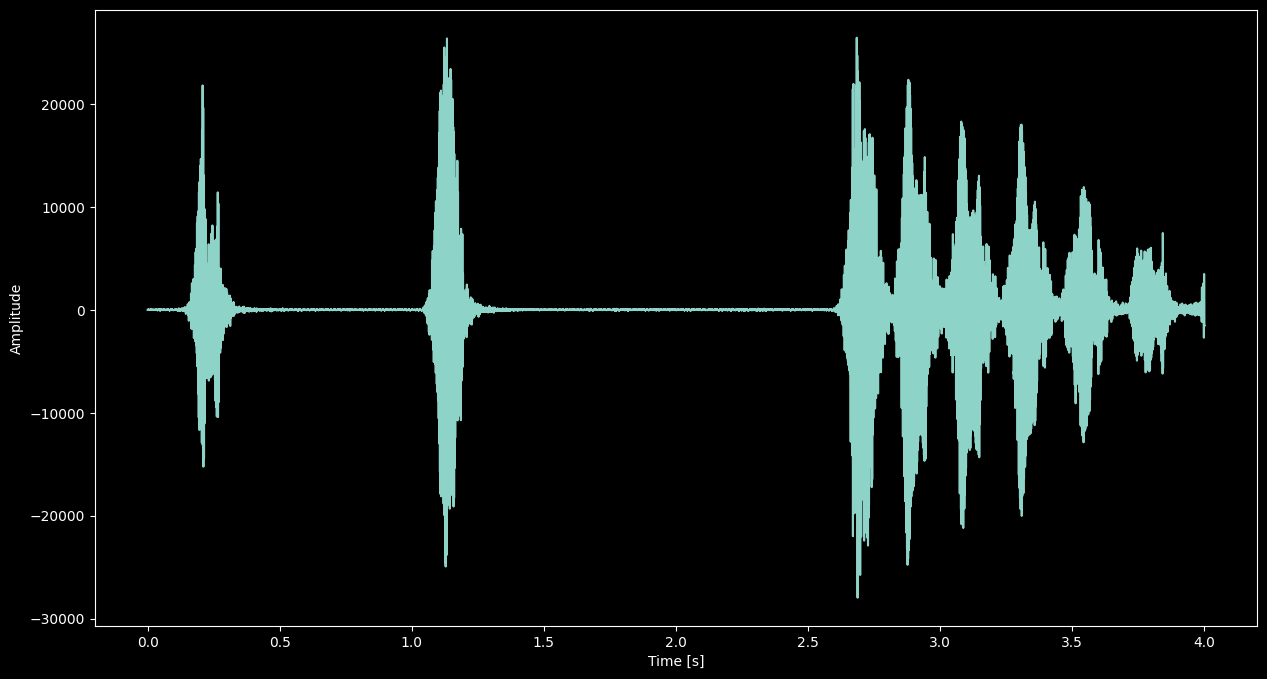

In [18]:
display_audio_signal(music_test)

We have already obtained a certain amount of information that we can study globally on the dataset to examine, among other things, the distribution of each of them.

In [19]:
def generate_audio_data_dataframe(metadata_df):
    data = []
    for index_num, row in tqdm(metadata_df.iterrows()):
        try:
            # Extract information from the WAV file
            sampling_rate, signal = wavfile.read(row['signal_path'])
        except ValueError:
            print(f"The {row['fsID']} file does not have a supported format.")
            continue
        
        n_samples = signal.shape[0]
        n_channels = signal.shape[1] if signal.ndim == 2 else 1
        T = n_samples / sampling_rate # the duration of the signal
        
        # In the line below we change format of some data to get:
        # -sampling_rate in kHz
        # -duration in seconds with 1 decimal
        data.append([row['fsID'], signal, sampling_rate*1e-3, n_samples, n_channels, round(T, 1), row['classID'], row['class']])
    
    df = pd.DataFrame(data, columns=['fsID', 'signal', 'sampling_rate', 'n_samples', 'n_channels', 'duration', 'classID', 'class'])
    
    # Save the dataframe as a pickle file
    df.to_pickle(AUDIO_DATA_PATH)

In [20]:
# Uncommente the following line to generate audio data dataframe 
# generate_audio_data_dataframe(metadata)

In [21]:
# Load audio data from audio_data.pkl file
audio_data = pd.read_pickle(AUDIO_DATA_PATH)

In [22]:
audio_data.head()

,fsID,signal,sampling_rate,n_samples,n_channels,duration,classID,class
0,100032,"[[-150, -148], [-160, -157], [-151, -151], [-1...",44.1,14004,2,0.3,3,dog_bark
1,100263,"[[171, 63], [157, 86], [130, 96], [78, 105], [...",44.1,176400,2,4.0,2,children_playing
2,100263,"[[-77, -168], [-58, -159], [-37, -141], [-20, ...",44.1,176400,2,4.0,2,children_playing
3,100263,"[[-59, 76], [-39, 40], [-27, 13], [-39, -11], ...",44.1,176400,2,4.0,2,children_playing
4,100263,"[[159, -52], [185, -16], [231, 40], [269, 103]...",44.1,176400,2,4.0,2,children_playing


In [23]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8723 entries, 0 to 8722
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fsID           8723 non-null   int64  
 1   signal         8723 non-null   object 
 2   sampling_rate  8723 non-null   float64
 3   n_samples      8723 non-null   int64  
 4   n_channels     8723 non-null   int64  
 5   duration       8723 non-null   float64
 6   classID        8723 non-null   int64  
 7   class          8723 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.3+ KB


We go from 8732 to 8723 audios, we have a loss of 9 elements. However, this dataset remains representative of metada.

We can now see some distributions:

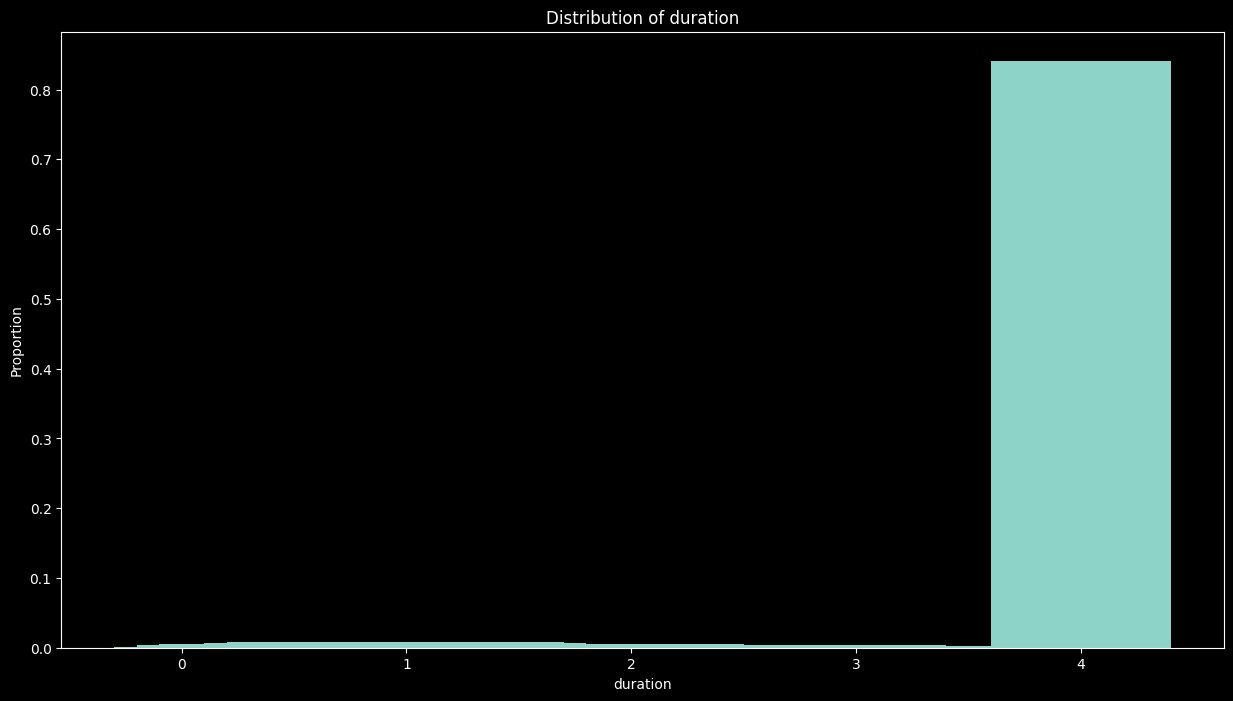

In [24]:
# Distribution of duration
display_distribution(audio_data, 'duration')

As we have seen in *metadata*, all the sounds are very short with a majority at 4s.

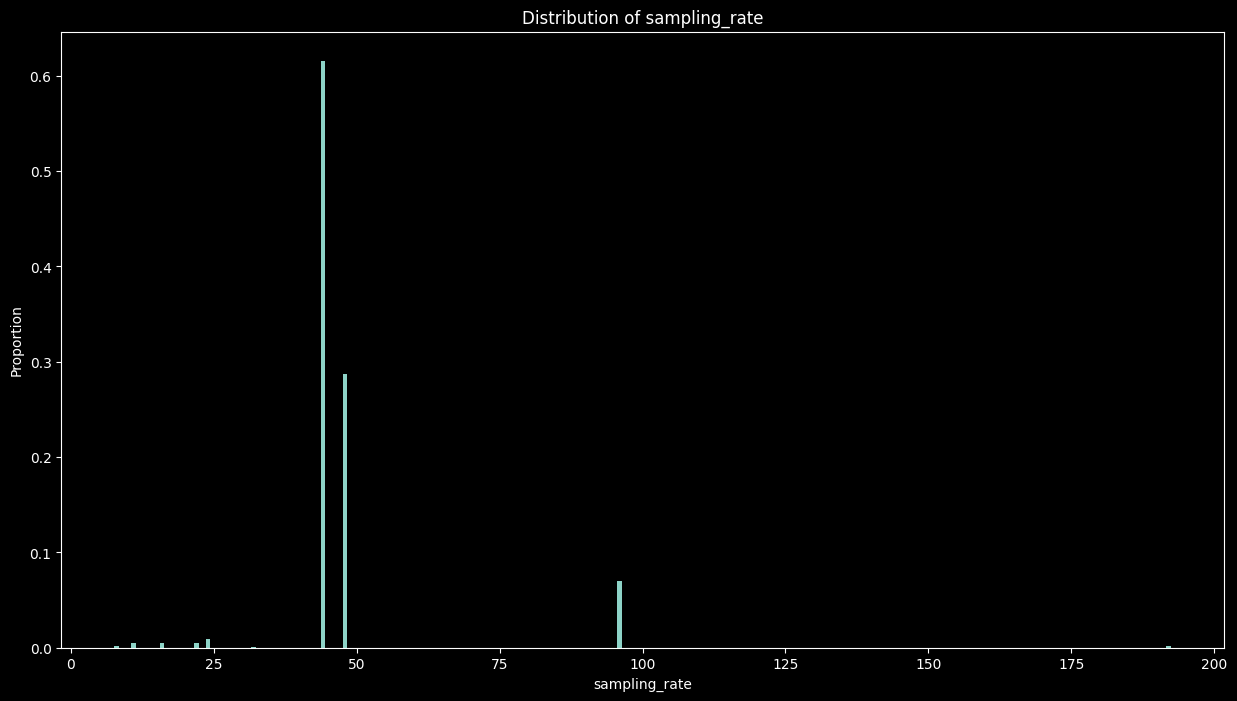

In [25]:
# Distribution of sampling rates
display_distribution(audio_data, 'sampling_rate')

We can conclude that the audio recordings in the dataset are mostly low or medium frequency recordings, which do not require a high sampling rate to be correctly represented digitally. This also indicates that the recordings were made in a context where accuracy was not the priority, and indeed we are studying urban sounds!

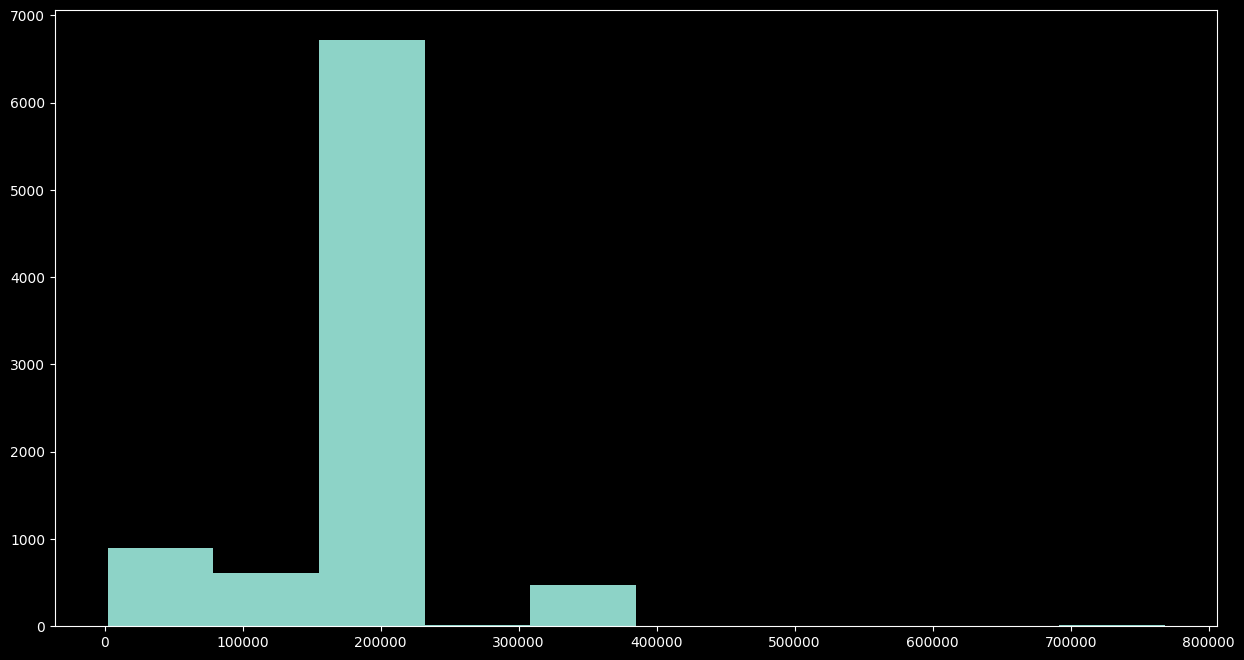

In [26]:
# Distribution of samples
plt.hist(audio_data['n_samples'])
plt.show()

In the context of urban sounds, the fact that there is a significantly higher number of sounds with an n_samples of 200_000 may suggest that this duration corresponds to the typical length of a sound segment in the urban environment. However, we could see that the average of the recordings is 4s, which then rather supports that this value of 200_000 is rather related to the temporal constraint.

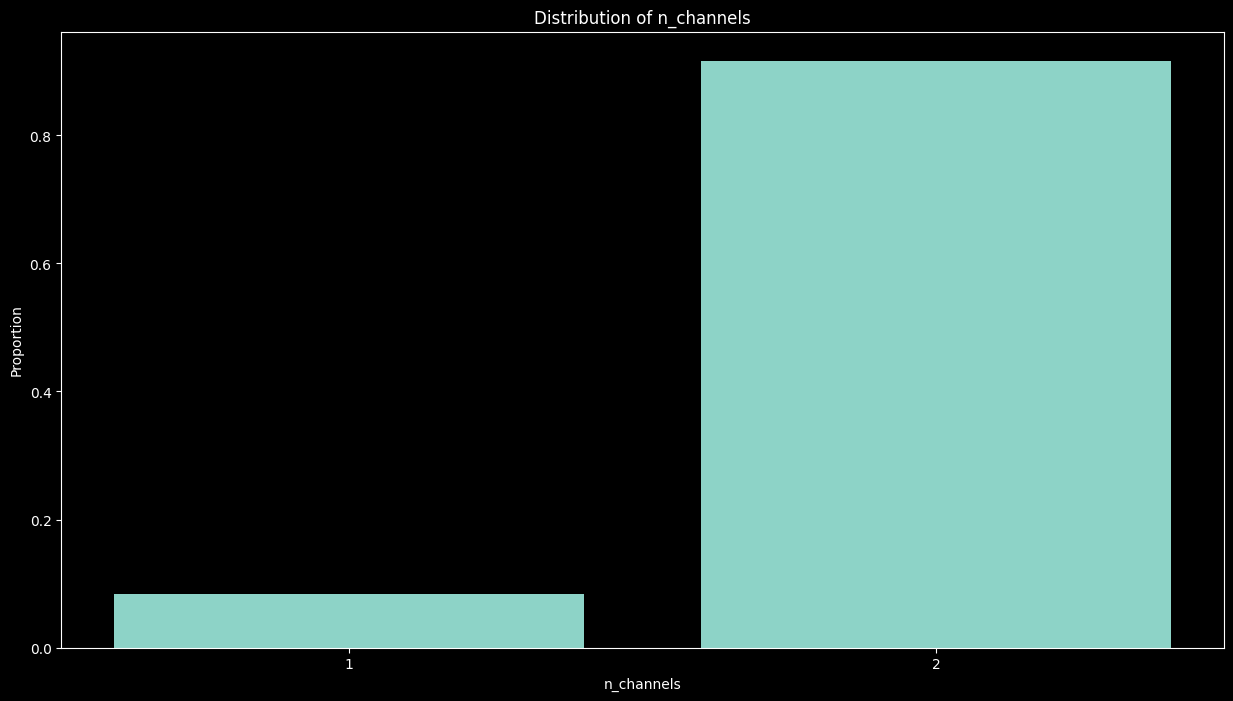

In [27]:
# Distribution of sampling rates
display_distribution(audio_data, 'n_channels', list(np.unique(audio_data['n_channels'])))

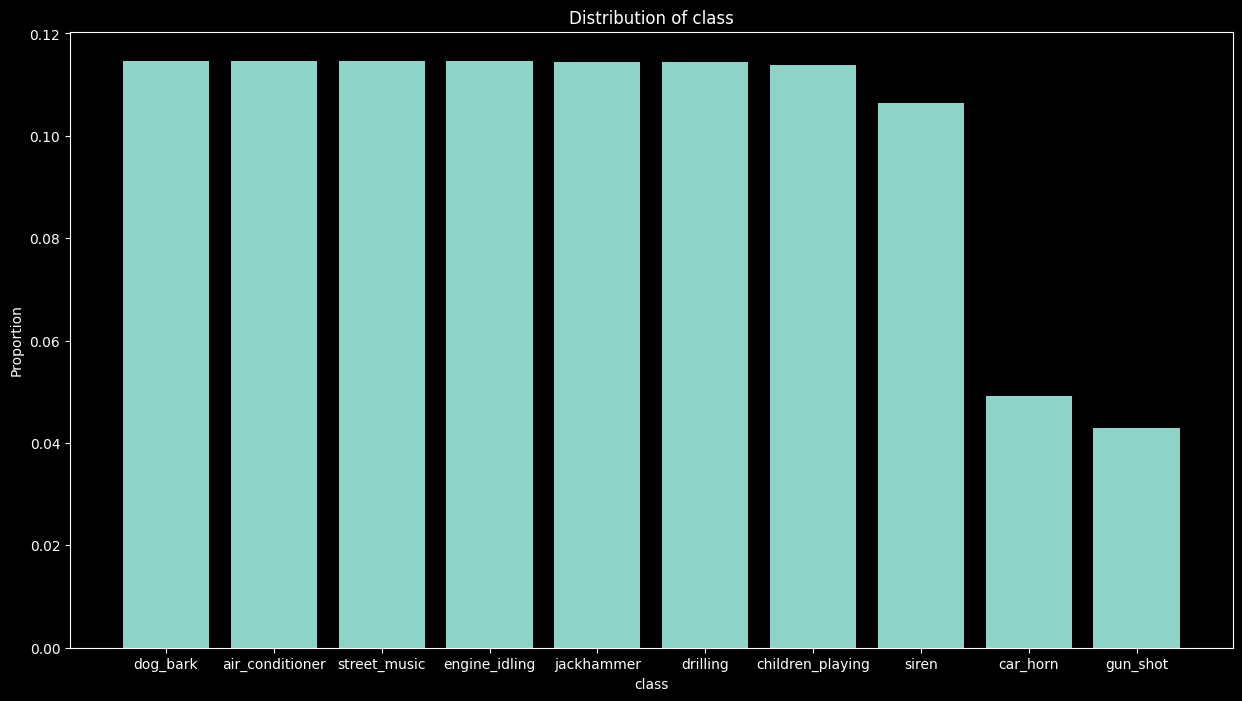

In [28]:
# Distribution of classes
display_distribution(audio_data, 'class', list(np.unique(audio_data['class'])))

## Part 2, we will use the librosa library to analyze our audio data.

*librosa* is a Python package for music and audio processing, providing a variety of functions for tasks such as feature extraction, audio analysis and visualization. It is built on top of other scientific Python packages, such as NumPy, SciPy and Matplotlib, and provides an easy-to-use interface for working with audio data. With librosa, we can load audio files, perform spectral and time-domain analysis, extract features such as mel spectrograms, and much more. Unlike the uncompressed .wav format used in Part 1, librosa can handle various audio formats, such as MP3 and FLAC, and can also perform resampling and normalization to ensure consistency across different audio files.

In [29]:
# Display class name of the signal
class_name = metadata.at[TEST_INDEX, 'class']
print(f'Class name: {class_name}')

Class name: dog_bark


In [30]:
# Listen to the audio signal
ipd.Audio(music_test)

In [31]:
# Load the test file using the librosa.load
test_librosa_signal, test_librosa_sr = librosa.load(music_test)
print(
    f'Signal: {test_librosa_signal}',
    f'Signal shape: {test_librosa_signal.shape}',
    f'Sampling rate: {test_librosa_sr * 1e-3} kHz', # multiply by 10^-3 to get kHz
    sep='\n')

Signal: [-0.00011662 -0.00017163 -0.00017833 ... -0.04541198 -0.04675572
 -0.05040179]
Signal shape: (88200,)
Sampling rate: 22.05 kHz


We already observe a difference in the results with the use of librosa. Indeed, the signal and the associated frequency is not at all the same as when using wavfile. All this comes from the wish of librosa to simplify and add default parameters to their library. For more information see [Why resample on load?](https://librosa.org/blog/2019/07/17/resample-on-load/). For our classification task it helps us a lot, in fact we don't need to do any preprocessing at these levels!

The signal is 4.0s long.
The sampling rate is 22.05 kHz, with 88200 samples.
There is 1 audio channel(s).


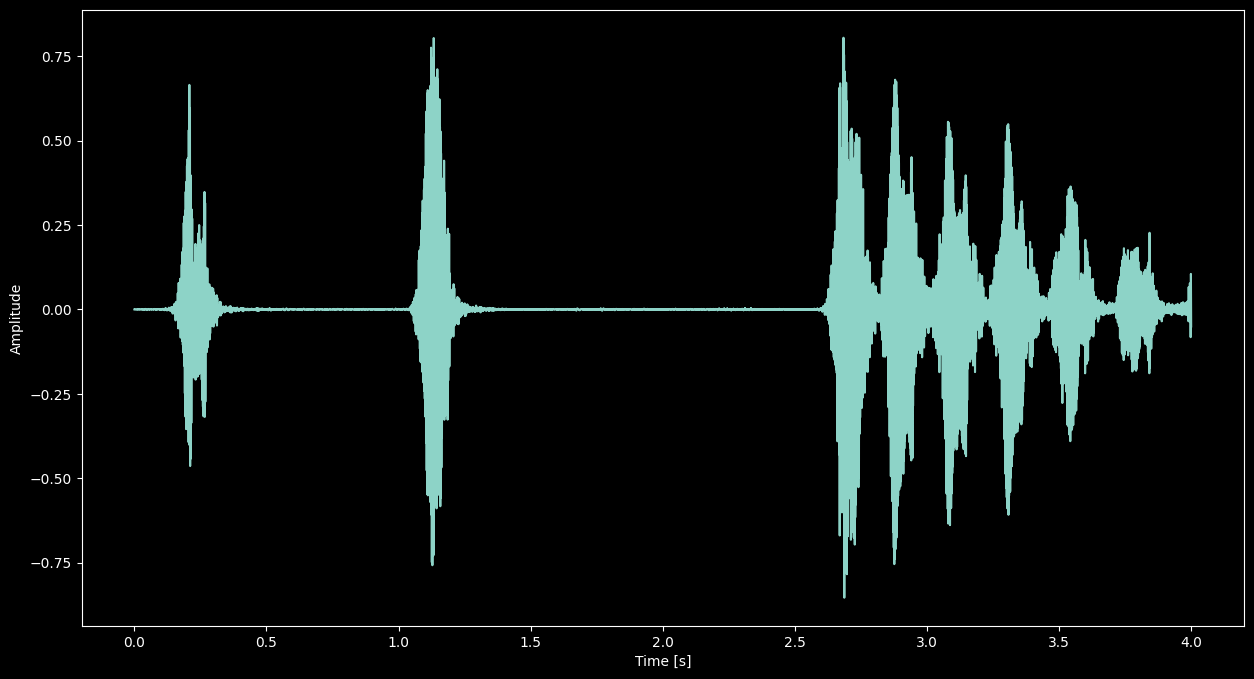

In [32]:
display_audio_signal(music_test, LIBROSA)

In fact, for each of our signals, we will have a sampling rate of 22.05 KHz and only 1 audio channel.

In [33]:
def display_audio_spectrogram(signal, sr):
    X = librosa.stft(signal) # represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows
    X_dB = librosa.amplitude_to_db(np.abs(X)) # convert an amplitude spectrogram to dB-scaled spectrogram
    librosa.display.specshow(X_dB, sr=sr, x_axis='time', y_axis='hz')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(top=2000)
    plt.colorbar(format='%+2.0f dB');
    plt.grid(True)

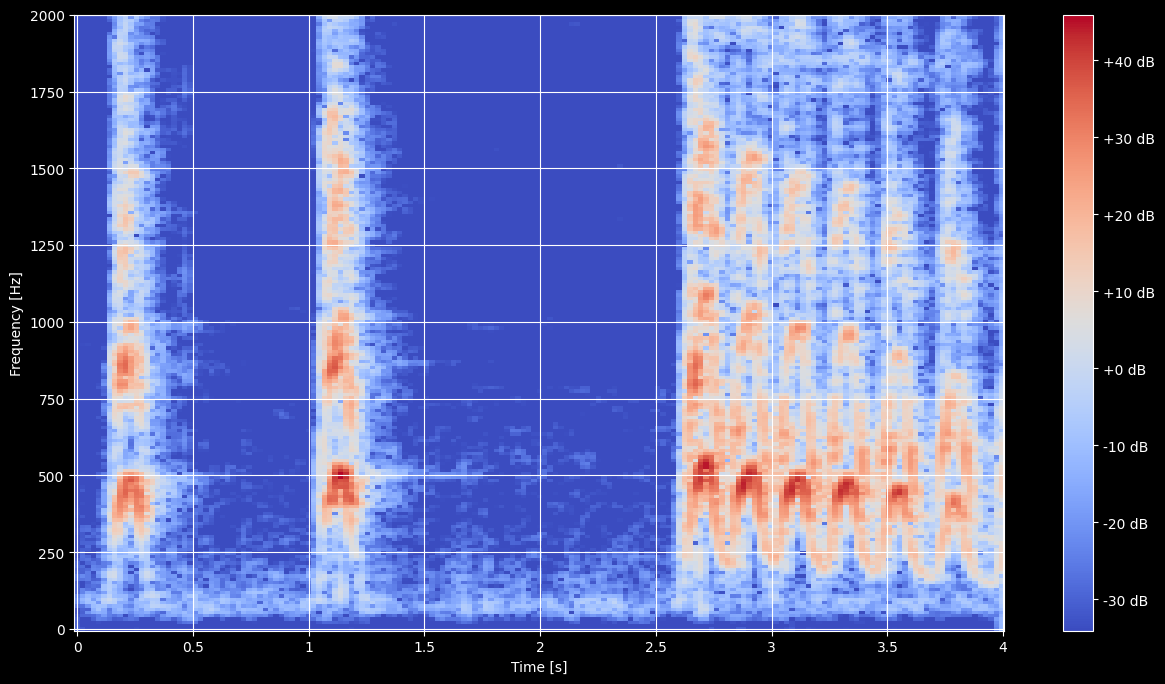

In [34]:
# We can display the associated spectrogram 
display_audio_spectrogram(test_librosa_signal, test_librosa_sr)

In [35]:
def display_audio_mel_spectrogram(signal, sr):
    mel_spect = librosa.feature.melspectrogram(y=signal, sr=sr)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(top=2000)
    plt.colorbar(format='%+2.0f dB');
    plt.grid(True)

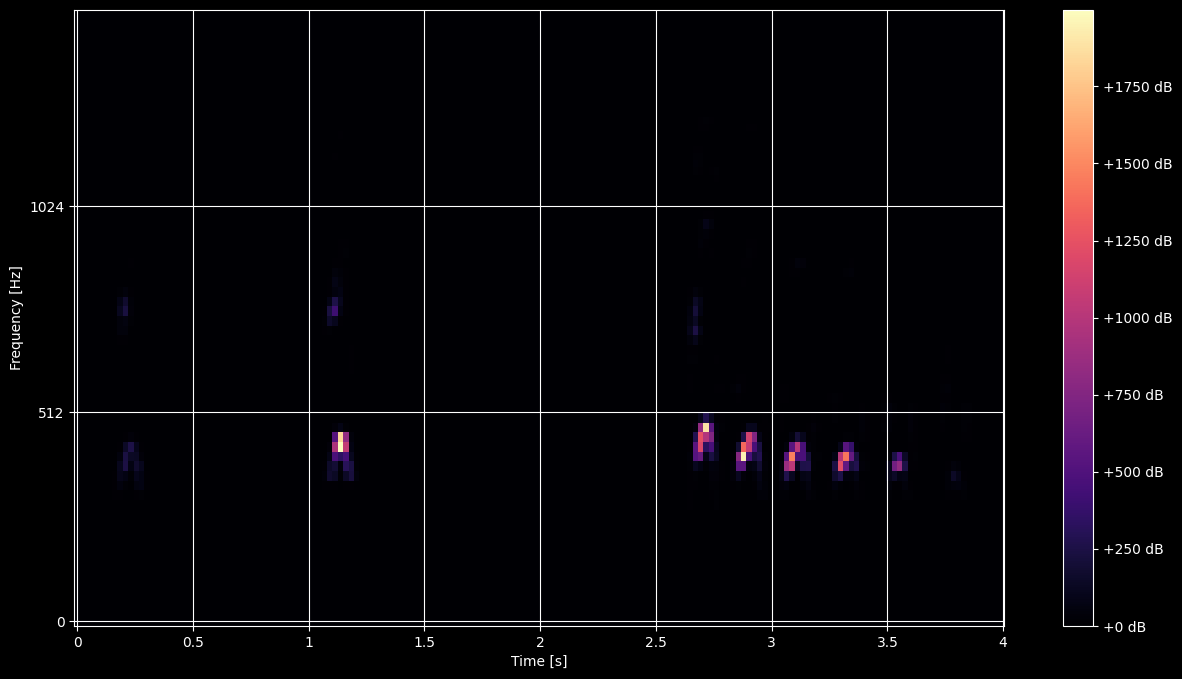

In [36]:
# We can display the associated mel spectrogram 
display_audio_mel_spectrogram(test_librosa_signal, test_librosa_sr) # compute a mel-scaled spectrogram

The melspectrogram is a graphical representation of the energy of sound distributed in the different frequencies of the audible frequency band. It is a modified version of the classical spectrogram, which uses a non-linear frequency scale (Mel scale) to better represent human perception of frequencies. The melspectrogram is obtained by applying a short term Fourier transform (STFT) on the audio signal, then filtering the resulting frequencies using a Mel filter bank. This representation is very useful for the analysis of the harmonic structure of a sound.

In [37]:
def display_audio_mfccs(signal, sr):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=signal, sr=sr)
    # Plot MFCCs
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.tight_layout()
    plt.show()

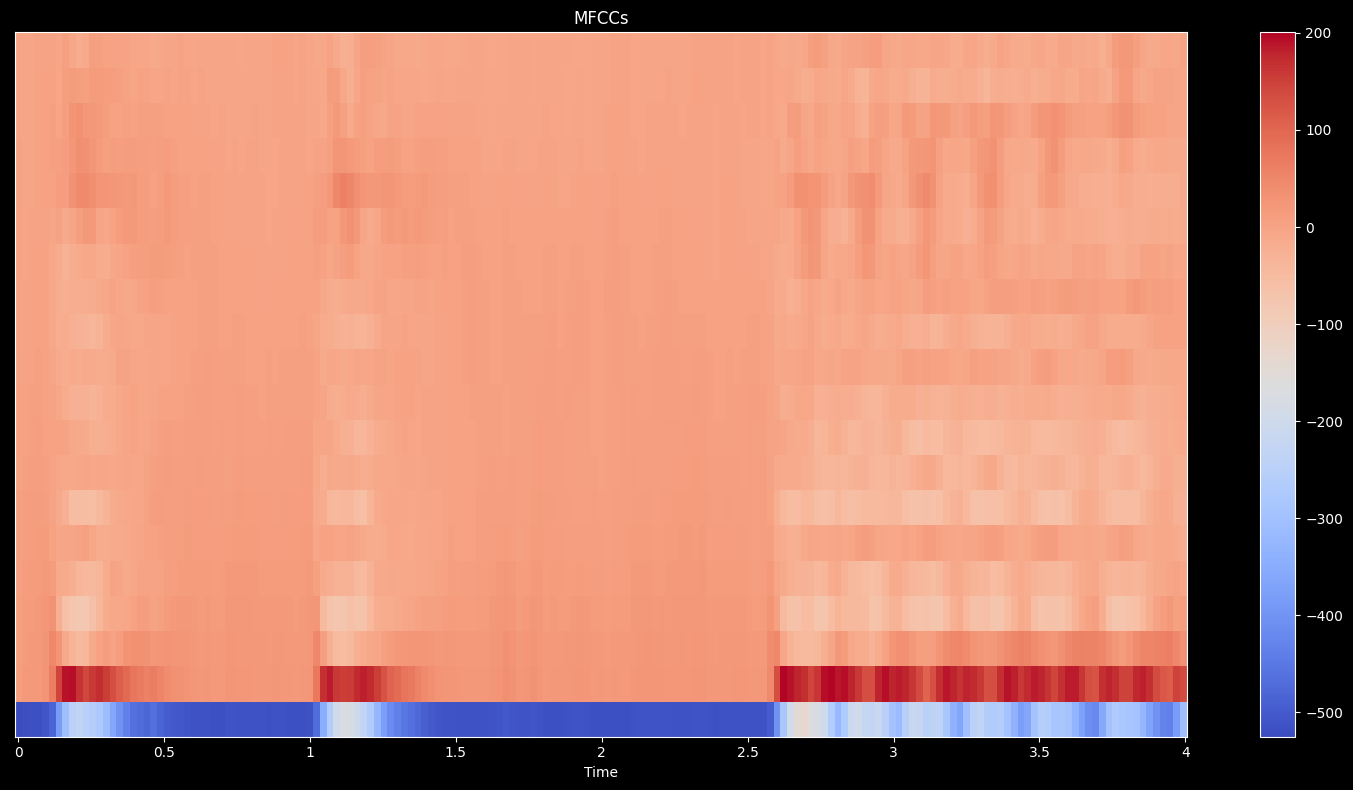

In [38]:
# We can visualize the associated mfccs (Mel-Frequency Cepstral Coefficients)
display_audio_mfccs(test_librosa_signal, test_librosa_sr)

Mel-frequency cepstral coefficients (MFCCs) are coefficients that capture the spectral structure of sound. They are often used for speech recognition tasks, as they allow to efficiently represent the human voice and to distinguish it from other sounds. MFCCs are computed by performing a discrete cosine transform (DCT) on the logarithm of the power spectrum obtained by the short-time Fourier transform (STFT). 

In [39]:
# We can display differents signals

In [40]:
# Display list of classes
list(metadata['class'].unique())

['dog_bark',
 'children_playing',
 'car_horn',
 'air_conditioner',
 'street_music',
 'gun_shot',
 'siren',
 'engine_idling',
 'jackhammer',
 'drilling']

<Figure size 1500x800 with 0 Axes>

class name: dog_bark
The signal is 0.3s long.
The sampling rate is 22.05 kHz, with 7002 samples.
There is 1 audio channel(s).


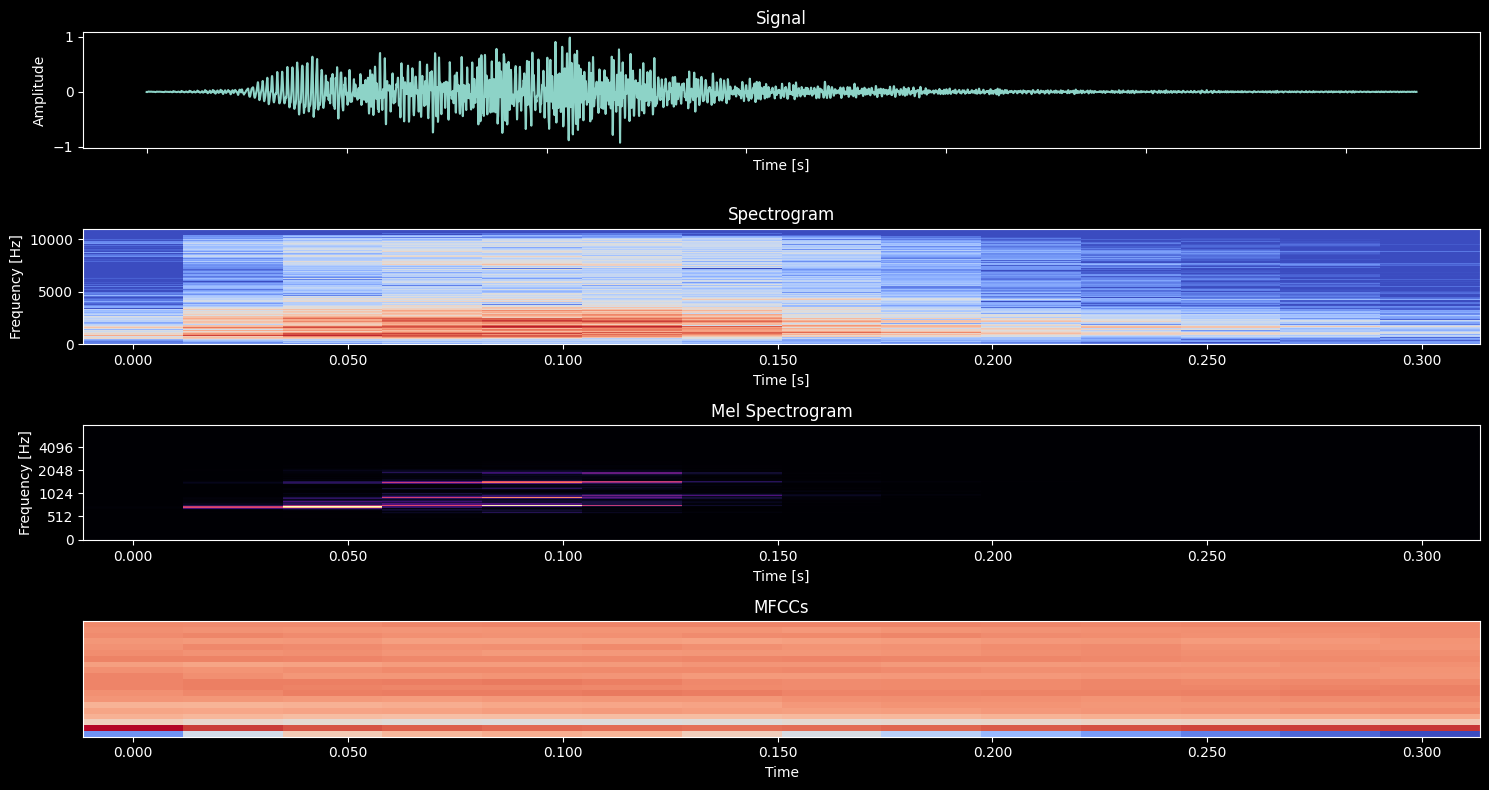

class name: dog_bark
The signal is 4.0s long.
The sampling rate is 22.05 kHz, with 88200 samples.
There is 1 audio channel(s).


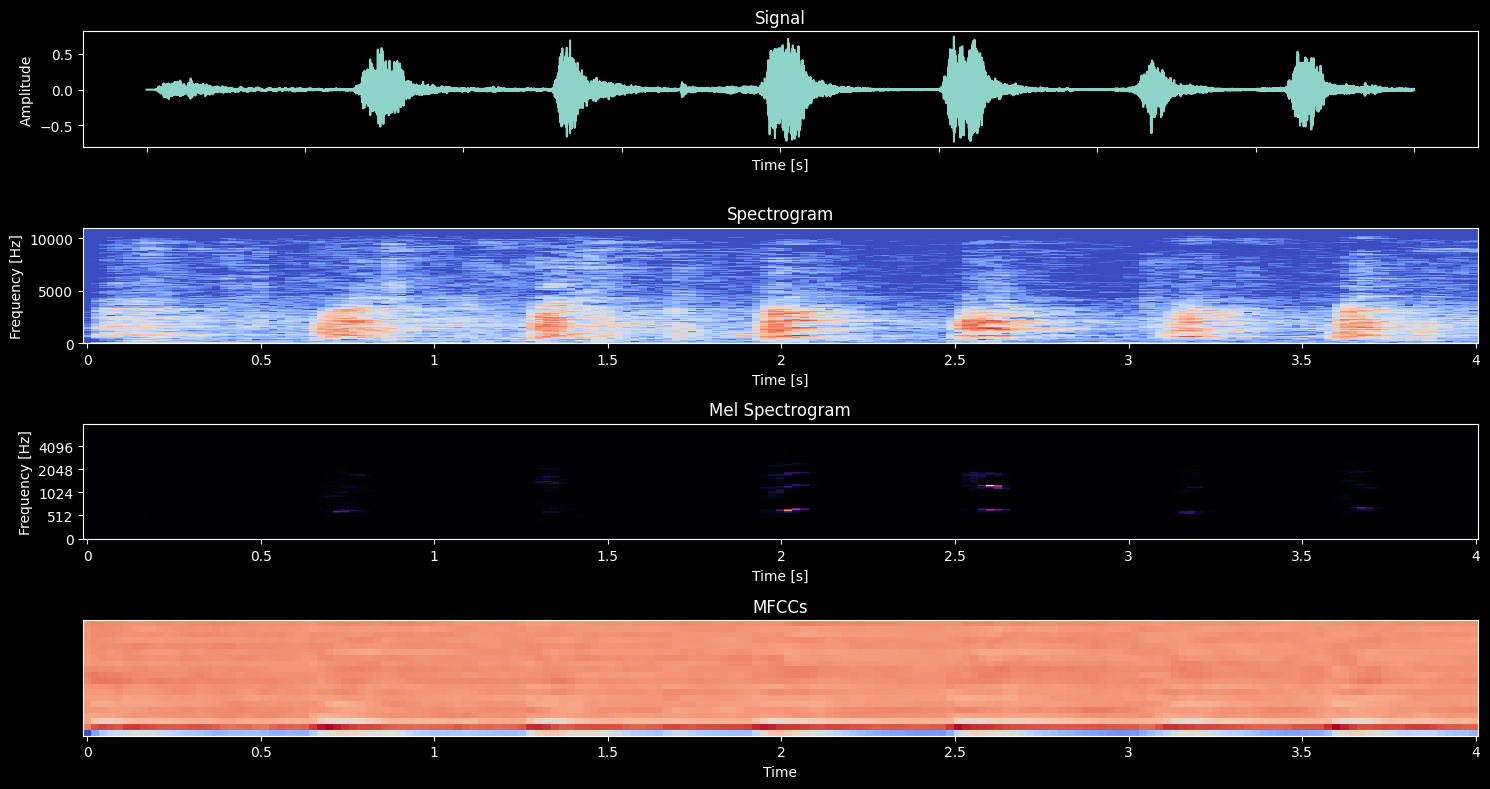

In [41]:
classes = ['dog_bark'] # add element from the list above to display more classes
nb_examples = 2 # change this number to have more examples
librosa_get_examples(metadata, nb_examples, classes)

In summary, the melspectrogram and MFCCs are very useful tools in audio signal processing. The melspectrogram allows to visualize the energy of a sound in different frequencies, while the MFCCs allow to capture the spectral structure of a sound in the form of feature vectors. These tools are widely used in tasks such as speech recognition, speaker detection, music analysis and many others. This is why we will use them for our classification problem!

In [42]:
def extract_melspectrogram(filename):
    signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') # kaiser_fast: faster method
    feature = librosa.feature.melspectrogram(y=signal, sr=sample_rate)
    scaled_feature = np.mean(feature.T, axis=0) #  reduce the dimensionality of the data
    return scaled_feature

def generate_melspectrogram_dataframe(metadata_df):
    data = []
    for index_num, row in tqdm(metadata_df.iterrows()):
        try:
            # Extract melspectrogram
            feature = extract_melspectrogram(row['signal_path'])
        except ValueError:
            print(f"The {row['fsID']} file does not have a supported format.")
            continue
        
        data.append([feature, row['class']])
    
    df = pd.DataFrame(data, columns=['melspectrogram_features', 'class'])
    
    # Save the dataframe as a pickle file
    df.to_pickle(MELSPECTROGRAM_PATH)

In [43]:
def extract_mfccs(filename):
    signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') # kaiser_fast: faster method
    feature = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=64)
    scaled_feature = np.mean(feature.T, axis=0) #  reduce the dimensionality of the data
    return scaled_feature

def generate_mfccs_dataframe(metadata_df):
    data = []
    for index_num, row in tqdm(metadata_df.iterrows()):
        try:
            # Extract mfccs
            feature = extract_mfccs(row['signal_path'])
        except ValueError:
            print(f"The {row['fsID']} file does not have a supported format.")
            continue
        
        data.append([feature, row['class']])
    
    df = pd.DataFrame(data, columns=['mfccs_features', 'class'])
    
    # Save the dataframe as a pickle file
    df.to_pickle(MFCCS_PATH)

In [44]:
# We can create a dataframe with all melspectrogram of signals
# Uncommente the following line to generate audio features dataframe 
# generate_melspectrogram_dataframe(metadata)

In [45]:
# We can create a dataframe with all mfccs of signals
# Uncommente the following line to generate audio features dataframe 
# generate_mfccs_dataframe(metadata)

## Part 3, load and see dataframes

In [46]:
df_mfccs = load_data(MFCCS_PATH, True)

In [47]:
df_spec = load_data(MELSPECTROGRAM_PATH, True)

In [48]:
df_mfccs.head()

,mfccs_features,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036358, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [49]:
df_spec.head()

,melspectrogram_features,class
0,"[2.3283628e-05, 0.00021359067, 0.0002844038, 0...",dog_bark
1,"[0.049608395, 0.049436085, 0.03691951, 0.02867...",children_playing
2,"[0.030883819, 0.027941372, 0.036278624, 0.0257...",children_playing
3,"[0.026432991, 0.032280095, 0.04545298, 0.03293...",children_playing
4,"[0.06138195, 0.040278364, 0.02294883, 0.015539...",children_playing


# Modeling

In [50]:
# Define usefull constants for model creation
EPOCHS = 100 # change number of EPOCHS to obtain better results
BATCH_SIZE = 32
PATIENCE = 10
CALLBACKS=[keras.callbacks.EarlyStopping(patience=PATIENCE)]
models = [] # list of all models that we will create

In [51]:
# Create label encoder for class labels (our y)
label_encoder = preprocessing.LabelEncoder()

In [52]:
# Define function to get best model with infos
def get_best_model(X_train, y_train, X_val, y_val, model_func, project_name):
    tuner = BayesianOptimization(
        model_func,
        objective='val_accuracy',
        max_trials=10,
        seed=42,
        project_name=project_name)
    
    # Perform the hyperparameter search
    tuner.search(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val))
    
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print('\n')
    print("Best hyperparameters:")
    for key, value in best_hyperparameters.values.items():
        print(f"{key}: {value}")
    print('\n')
    
    # Build the model with the best hyperparameters
    best_model = tuner.hypermodel.build(best_hyperparameters)
    
    
    # Training the best model
    history = best_model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[CALLBACKS]
    )
    print('\n')
    # Display learning curves
    display_leaning_curves(history)

    return best_model

In [53]:
def visualize_cnn_input_data(X, y, shape, n=4, classID=None):
    fig, axs = plt.subplots(n, 1, figsize=(15, n))
    count = 0
    for i in range(len(y)):
        if classID != None and y[i] != classID:
            continue
        im = axs[count].imshow(np.squeeze(X[i]).reshape(shape))
        axs[count].set_yticks([])
        class_name = label_encoder.inverse_transform([y[i]])
        axs[count].set_title('Class: ' + str(class_name[0]))
        count += 1
        if count == n:
            break
    fig.colorbar(im, ax=axs, orientation='vertical')
    plt.show()

## 1: Fully connected neural network with mfccs

In [54]:
# Create all sets
y_FC = label_encoder.fit_transform(df_mfccs["class"].values)
X_FC = normalize_w_librosa(df_mfccs["mfccs_features"]) # use norm 2
X_train_FC, X_test_FC, X_val_FC, y_train_FC, y_test_FC, y_val_FC = generate_data(X_FC, y_FC)

Shape of training samples = (5238, 64)
Shape of validation samples = (1747, 64)
Shape of testing samples = (1747, 64)


In [55]:
def create_model_FC(hp):
    # Define input layer
    inputs = keras.layers.Input(shape=(64,))
    x = inputs
    
    # Define number of hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        x = keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                         activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid']),
                         name="hidden_layer_" + str(i))(x)
        
        x = keras.layers.Dropout(hp.Float('dropout_' + str(i), 0, 0.5, step=0.1),
                           name="dropout_" + str(i))(x)
    
    # Define output layer
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    
    # Create the model
    model = keras.models.Model(inputs, outputs)
    
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  metrics=['accuracy'])
    
    return model

Trial 10 Complete [00h 00m 52s]
val_accuracy: 0.11791642755270004

Best val_accuracy So Far: 0.8992558717727661
Total elapsed time: 00h 07m 52s
INFO:tensorflow:Oracle triggered exit


Best hyperparameters:
num_layers: 2
units_0: 288
activation_0: relu
dropout_0: 0.2
optimizer: adam
units_1: 512
activation_1: tanh
dropout_1: 0.4
units_2: 64
activation_2: sigmoid
dropout_2: 0.0
units_3: 320
activation_3: relu
dropout_3: 0.1


Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 2.0003 - accuracy: 0.2770 - val_loss: 1.7198 - val_accuracy: 0.4070
Epoch 2/100
164/164 [==============================] - 0s 3ms/step - loss: 1.5781 - accuracy: 0.4538 - val_loss: 1.4753 - val_accuracy: 0.5209
Epoch 3/100
164/164 [==============================] - 1s 4ms/step - loss: 1.3398 - accuracy: 0.5416 - val_loss: 1.3089 - val_accuracy: 0.5512
Epoch 4/100
164/164 [==============================] - 0s 3ms/step - loss: 1.1953 - accuracy: 0.5998 - val_loss: 1.1596 - val_accuracy: 0.6216


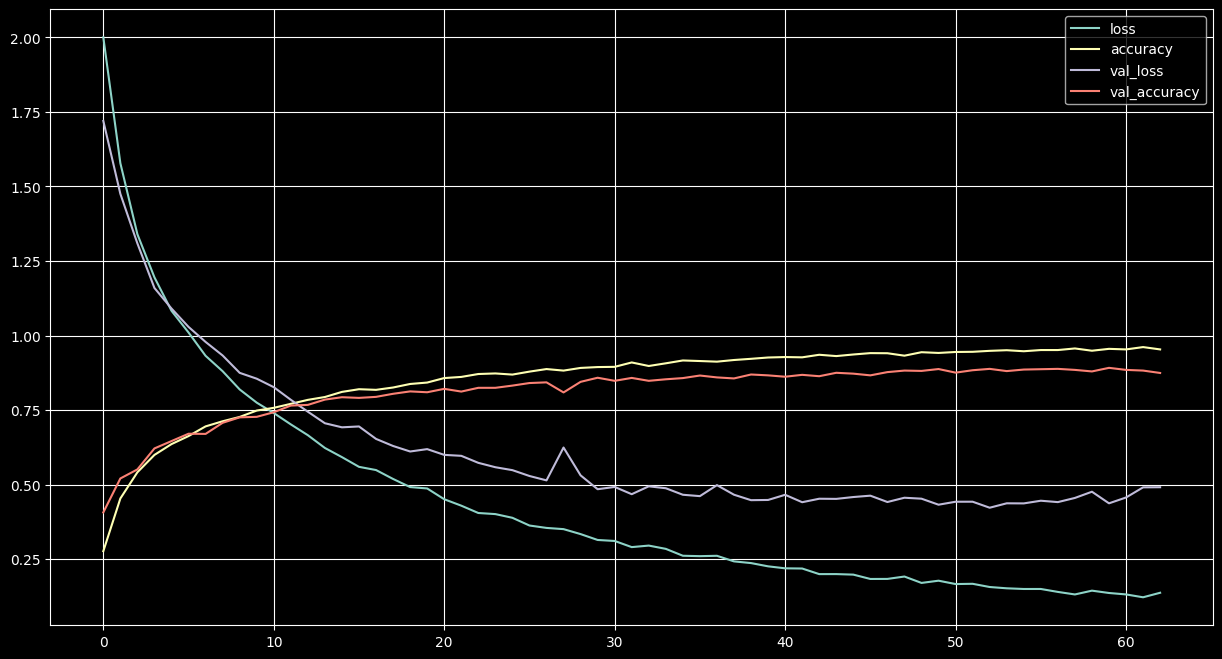

In [56]:
best_model_FC = get_best_model(X_train_FC, y_train_FC, X_val_FC, y_val_FC, create_model_FC, "FC")

In [57]:
# Evaluate the best model on the test data 
score_FC = evaluate_model(best_model_FC, X_test_FC, y_test_FC)

Evaluate on test data
55/55 [==============================] - 0s 1ms/step - loss: 0.4677 - accuracy: 0.8941
test loss, test acc: [0.4676923155784607, 0.8941041827201843]


In [58]:
# Add FC model to models list
models.append({'model': best_model_FC, 'score': score_FC})

## 2: Convolutional Neural Network (CNN) with mel spectrogram

In [59]:
# Create all sets
y_CNN_SPEC = label_encoder.fit_transform(df_spec["class"].values)
# Reshape X
X_ = np.array(df_spec['melspectrogram_features']).transpose()
X_CNN_SPEC = np.empty([8732, 128])
for i in range(8732):
    X_CNN_SPEC[i] = (X_[i])
X_CNN_SPEC = X_CNN_SPEC.reshape(X_CNN_SPEC.shape[0], 16, 8, 1)
X_train_SPEC, X_test_SPEC, X_val_SPEC, y_train_SPEC, y_test_SPEC, y_val_SPEC = generate_data(X_CNN_SPEC, y_CNN_SPEC)

Shape of training samples = (5238, 16, 8, 1)
Shape of validation samples = (1747, 16, 8, 1)
Shape of testing samples = (1747, 16, 8, 1)


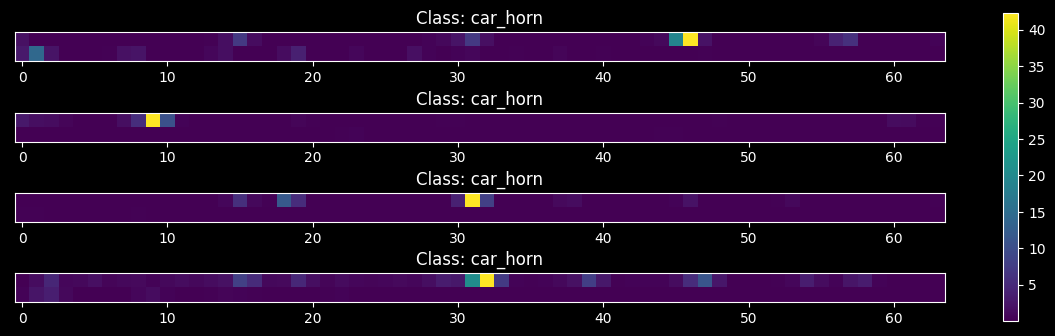

In [60]:
visualize_cnn_input_data(X_train_SPEC, y_train_SPEC, (2, 64), 4, 1)

In [61]:
def create_model_CNN_SPEC(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(hp.Int('num_filters', 32, 128, 16), 
                                  (hp.Choice('filter_size', values=[3, 5])), 
                                  padding="same",
                                  activation=hp.Choice('activation', values=['relu', 'tanh']), 
                                  input_shape=(16, 8, 1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(hp.Int('num_filters', 32, 128, 16), 
                                  (hp.Choice('filter_size', values=[3, 5])),  
                                  padding="same", 
                                  activation=hp.Choice('activation', values=['relu', 'tanh'])))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, 0.1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hp.Int('dense_units', 64, 256, 64), activation=hp.Choice('activation', values=['relu', 'tanh'])))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  metrics=['accuracy'])
    return model

Trial 10 Complete [00h 03m 52s]
val_accuracy: 0.8420149087905884

Best val_accuracy So Far: 0.8580423593521118
Total elapsed time: 00h 33m 57s
INFO:tensorflow:Oracle triggered exit


Best hyperparameters:
num_filters: 80
filter_size: 3
activation: relu
dropout_rate: 0.1
dense_units: 256
learning_rate: 0.001


Epoch 1/100
164/164 [==============================] - 4s 21ms/step - loss: 2.1113 - accuracy: 0.3194 - val_loss: 1.7961 - val_accuracy: 0.4242
Epoch 2/100
164/164 [==============================] - 3s 17ms/step - loss: 1.7150 - accuracy: 0.4357 - val_loss: 1.7369 - val_accuracy: 0.4270
Epoch 3/100
164/164 [==============================] - 3s 19ms/step - loss: 1.5309 - accuracy: 0.4863 - val_loss: 1.4071 - val_accuracy: 0.5375
Epoch 4/100
164/164 [==============================] - 3s 17ms/step - loss: 1.3891 - accuracy: 0.5372 - val_loss: 1.3832 - val_accuracy: 0.5472
Epoch 5/100
164/164 [==============================] - 3s 16ms/step - loss: 1.2709 - accuracy: 0.5750 - val_loss:

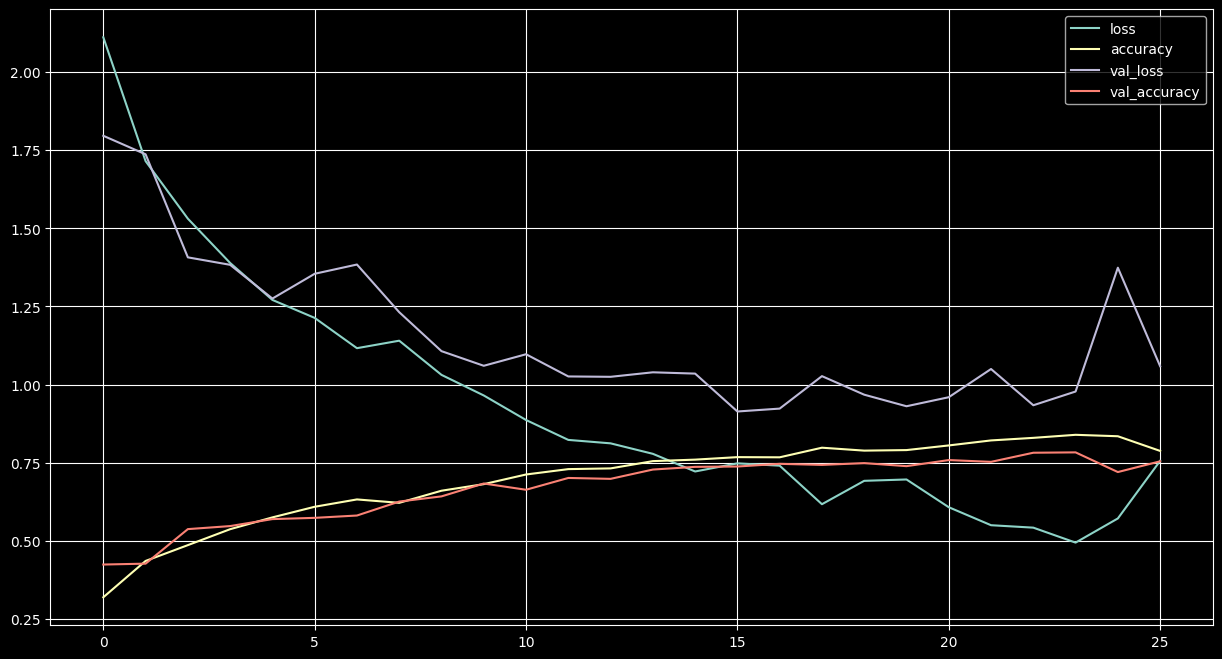

In [62]:
best_model_CNN_SPEC = get_best_model(X_train_SPEC, y_train_SPEC, X_val_SPEC, y_val_SPEC, create_model_CNN_SPEC, "CNN_SPEC")

In [63]:
# Evaluate the best model on the test data 
score_CNN_SPEC = evaluate_model(best_model_CNN_SPEC, X_test_SPEC, y_test_SPEC)

Evaluate on test data
55/55 [==============================] - 0s 6ms/step - loss: 1.1113 - accuracy: 0.7562
test loss, test acc: [1.11134934425354, 0.756153404712677]


In [64]:
# Add CNN SPEC model to models list
models.append({'model': best_model_CNN_SPEC, 'score': score_CNN_SPEC})

## 3: Convolutional Neural Network (CNN) with mfccs

In [65]:
# Create all sets
y_CNN_MFCCS = label_encoder.fit_transform(df_mfccs["class"].values)
# Reshape 
X_CNN_MFCCS = np.array(df_mfccs["mfccs_features"].tolist()).reshape(df_mfccs["mfccs_features"].shape[0], 64, 1, 1)
X_train_MFCCS, X_test_MFCCS, X_val_MFCCS, y_train_MFCCS, y_test_MFCCS, y_val_MFCCS = generate_data(X_CNN_MFCCS, y_CNN_MFCCS)

Shape of training samples = (5238, 64, 1, 1)
Shape of validation samples = (1747, 64, 1, 1)
Shape of testing samples = (1747, 64, 1, 1)


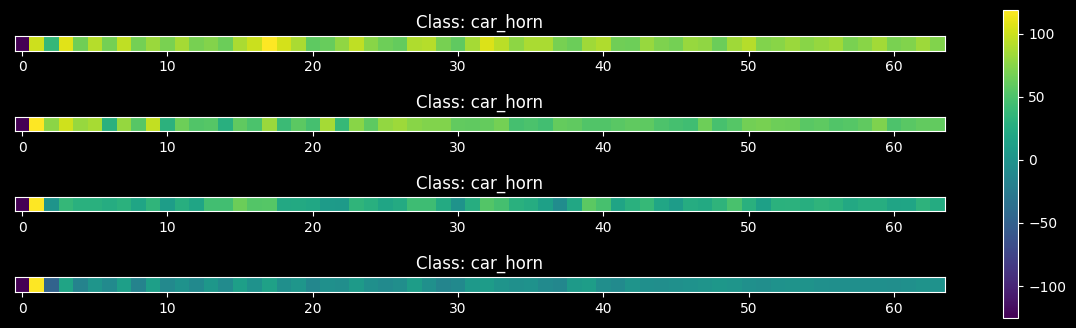

In [66]:
visualize_cnn_input_data(X_train_MFCCS, y_train_MFCCS, (1, 64), 4, 1)

In [67]:
def create_model_CNN_MFCCS(hp):
    model = keras.models.Sequential()
    
    # Tune the hyperparameters
    model.add(keras.layers.Conv2D(hp.Choice('num_filters', [32, 64, 128]), 
                                  (hp.Choice('filter_size', [3, 5]), 1), 
                                  activation=hp.Choice('activation', ['relu', 'tanh']), 
                                  input_shape=(64, 1, 1)))
    model.add(keras.layers.MaxPooling2D((hp.Choice('pool_size', [2, 3]), 1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(hp.Choice('dense_units', [64, 128, 256]), activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(keras.layers.Dropout(hp.Float('dropout_rate', 0, 0.5, step=0.1)))
    model.add(keras.layers.Dense(64, activation=hp.Choice('activation', ['relu', 'tanh'])))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']), 
                  metrics=['accuracy'])
    
    return model

Trial 10 Complete [00h 01m 31s]
val_accuracy: 0.8105323314666748

Best val_accuracy So Far: 0.9244418740272522
Total elapsed time: 00h 20m 21s
INFO:tensorflow:Oracle triggered exit


Best hyperparameters:
num_filters: 64
filter_size: 3
activation: relu
pool_size: 2
dense_units: 256
dropout_rate: 0.1
optimizer: sgd


Epoch 1/100
164/164 [==============================] - 2s 8ms/step - loss: 2.8674 - accuracy: 0.3454 - val_loss: 1.5758 - val_accuracy: 0.4333
Epoch 2/100
164/164 [==============================] - 1s 6ms/step - loss: 1.3867 - accuracy: 0.5294 - val_loss: 1.2782 - val_accuracy: 0.5913
Epoch 3/100
164/164 [==============================] - 1s 6ms/step - loss: 1.1742 - accuracy: 0.5974 - val_loss: 1.1178 - val_accuracy: 0.6325
Epoch 4/100
164/164 [==============================] - 1s 5ms/step - loss: 1.0318 - accuracy: 0.6523 - val_loss: 0.9458 - val_accuracy: 0.6926
Epoch 5/100
164/164 [==============================] - 1s 6ms/step - loss: 0.9241 - accuracy: 0.6802 - val_los

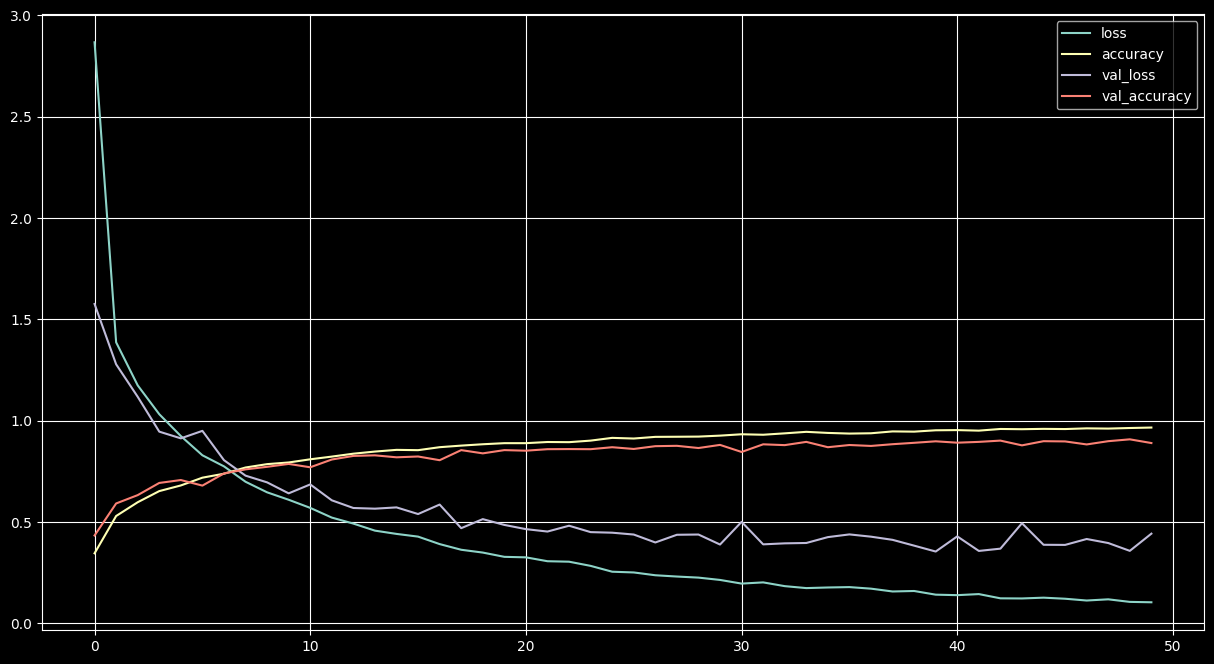

In [68]:
best_model_CNN_MFCCS = get_best_model(X_train_MFCCS, y_train_MFCCS, X_val_MFCCS, y_val_MFCCS, create_model_CNN_MFCCS, "CNN_MFCCS_2")

In [69]:
# Evaluate the best model on the test data 
score_CNN_MFCCS = evaluate_model(best_model_CNN_MFCCS, X_test_MFCCS, y_test_MFCCS)

Evaluate on test data
55/55 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.8981
test loss, test acc: [0.44692468643188477, 0.8981110453605652]


In [70]:
# Add CNN MFCCS model to models list
models.append({'model': best_model_CNN_MFCCS, 'score': score_CNN_MFCCS})

## Save best model

In [71]:
best_model = max(models, key=lambda x: x['score'])
best_model['model'].save(BEST_MODEL_PATH)

INFO:tensorflow:Assets written to: sound_project_model\assets


INFO:tensorflow:Assets written to: sound_project_model\assets


# Use the best model

In [72]:
final_model = keras.models.load_model(BEST_MODEL_PATH)

In [73]:
def extract_features(filename):
    signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') # kaiser_fast: faster method
    feature = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=64)
    scaled_feature = np.mean(feature.T, axis=0) #  reduce the dimensionality of the data
    return scaled_feature

def predict_w_model(model, audio):
    data = normalize_w_librosa(extract_features(audio))
    data = np.array(data.tolist())
    data = np.expand_dims(data, axis=(0, 2, 3))
    
    y_pred = model.predict(data).argmax(axis=1)
    print(f'Prediction: {list(label_encoder.inverse_transform(y_pred))[0]}')

In [74]:
# Song to test with our best model
AUDIO_TO_TEST_DATA_PATH = os.path.join(CREATION_PATH, "101415-3-0-2.wav") # change this audio with your song

In [75]:
ipd.Audio(AUDIO_TO_TEST_DATA_PATH)

In [76]:
predict_w_model(final_model, AUDIO_TO_TEST_DATA_PATH)

1/1 [==============================] - 0s 105ms/step
Prediction: gun_shot
